# 07 PJT

## API Server 제작

### 목표

#### 프로젝트 목표
- REST API 서버를 직접 구현합니다. (복습)

- 우리는 그동안 OpenWeatherMap API와 같이 누군가 만들어준 REST API Server를 사용하는 클라이언트였습니다.
- 이제는 `직접 서버를 구축`(DRF + 날씨 서버)해 볼 차례입니다.
    - 필수 요구사항
        1. DRF = API 구현
        2. `데이터`

#### 무슨 서버를 구축할까?
- 클라이언트에게 날씨 정보를 제공해주는 서버를 구축합니다.

- 사실 우리는 날씨 정보가 없습니다.
    - (비밀) 우리는 날씨 정보 원본 데이터를 OpenWeatherMap API 를 통해 가져올 것입니다.
    - (클라이언트는 이 사실을 모를 것입니다.)

#### 완성된 작품 예시
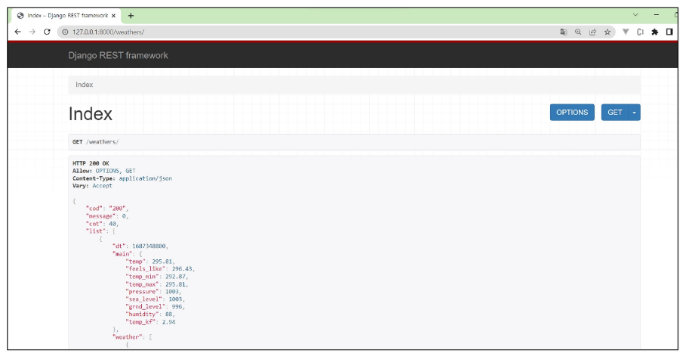

#### [참고] 백엔드 개발 vs 프론트엔드 개발
- 백엔드 개발
    - REST API 서버 개발 <- 이번 프로젝트 목표

- 프론트엔드 개발
    - REST API를 사용하여, 결과를 받아 화면 구성

    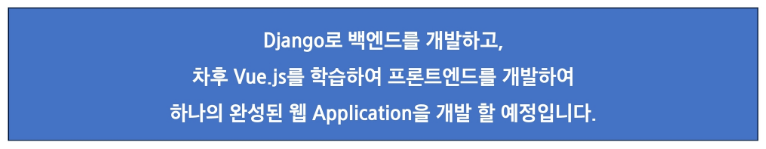

#### 정리
- 함께 개발하는 것
    - 날씨 정보를 제공하는 REST API 서버 개발
    - OpenWeatherMap API를 활용하여 데이터를 가져옵니다.
    - DB를 구축하여 날씨 정보를 DB에 저장 후 활용합니다.

## 날씨 데이터를 활용한 REST API Server 구축

### 준비사항 (API KEY 발급)

#### Quiz
왜 API KEY를 발급받아야 할까요?

#### OpenWeatherMap API - KEY 발급
- 사이트 접속 및 회원가입 진행

    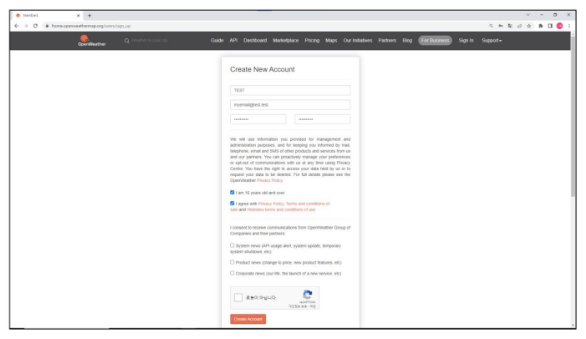
- API Keys 탭으로 이동

    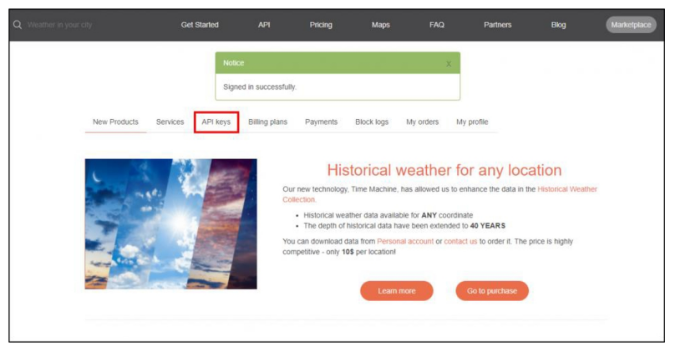

- API Key 복사
    - API Key를 복사하여 코드에서 활용합니다.

    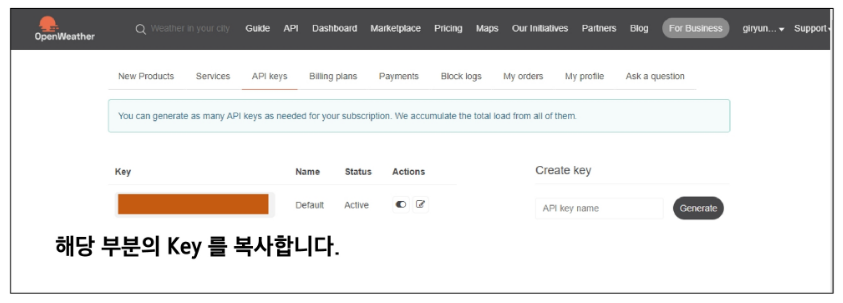

### 구현하기

#### [참고사항] 프로젝트 구조 
- 외부 API를 활용하여 데이터를 다운로드 받아 DB에 저장합니다. 
- 왜 DB에 저장하나요? 
    - DB에 저장하여 여러 번 외부로부터 데이터를 다운로드 받지 않도록 구성할 수 있습니다. 
    - 네트워크 연결이 불안정하거나 API 서비스가 일시적으로 중단된 경우에도 애플리케이션이 작동할 수 있습니다.

    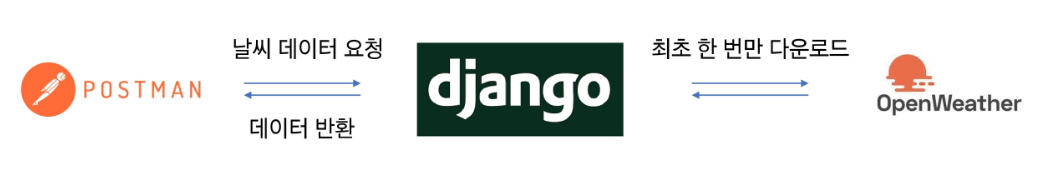

#### 구현 목표
- 구현하고자 하는 기능 목록은 다음과 같습니다.

    A. 서울의 5일 치 예보 데이터 확인 

    B. 예보 데이터 중 원하는 데이터만 DB에 저장 

    C. 저장된 전체 데이터 조회 
    
    D. 특정 조건의 데이터 확인하기: 섭씨 30도가 넘는 시간대만 조회


- API docs: https://openweathermap.org/forecast5

    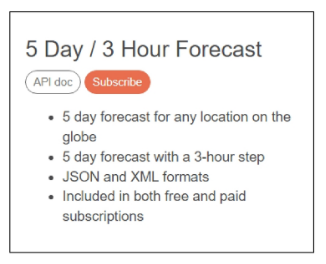

##### A. 서울의 5일 치 예보 데이터 확인
- API 에 요청을 보내고 데이터를 확인합니다.
    - DB에 저장하기 전 데이터를 확인하기 위한 과정입니다.

    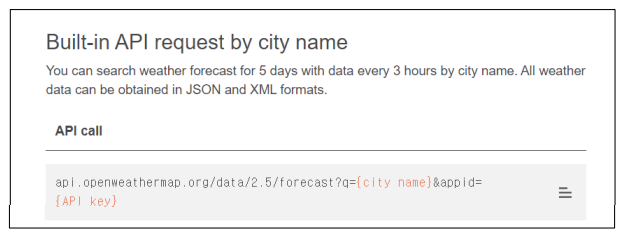
- views.py 작성 예시

    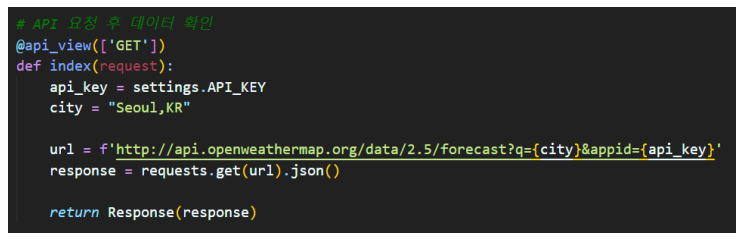

- 결과 예시

    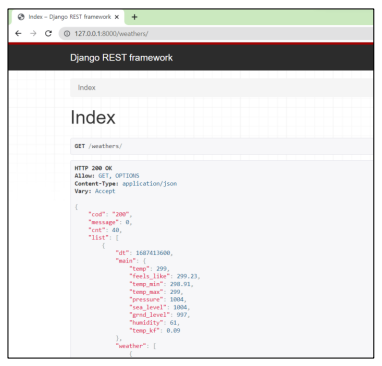

##### B. 예보 데이터 중 원하는 데이터만 DB에 저장
- A번에서 받은 데이터 중 “시간, 온도, 체감온도” 3가지만 사용합니다.
    - dt_txt: 시간
    - temp: 온도
    - feels_like: 체감 온도

    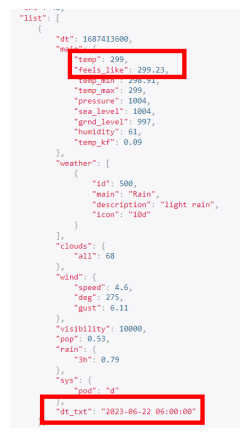

- 3가지 필드를 DB에 저장하기 위해 다음과 같이 models.py 를 작성합니다
```py
    from django.db import models 

    #Create your models here. 
    class Weather (models. Model): 
        dt_txt = models.DateTimeField() # 데이터 예측 시간 
        temp = models. FloatField() #온도(기본값: 켈빈) 
        feels_like = models. FloatField() # 체감온도(기본값: 켈빈)
```
- 마이그레이션 파일을 생성하고 DB에 반영합니다.
```shell
    $ python manage.py makemigrations
    $ python manage.py migrate
```
- 받아온 데이터 중 3가지 데이터만 추출하여 저장해야 합니다.
- key 값이 “list” 인 데이터를 반복하며 확인합니다.
- 시간은 UTC 로 저장되어 있어, 코드와 같이 한국 시간으로 변경하여 줍니다.
- 추출한 데이터를 Serializer 에 넣어줍니다.
- 데이터 유효성 검증 후 저장합니다.
```py
    for li in response.get('list'): 
        # dt(unix_time) 형태를 datetime 으로 변환해야 한다. 
        # 한국 시간대를 나타내는 timezone 객체 생성 
        dt_str = li.get('dt_txt') 
        dt = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S") 
        
        # 기존 시간대를 vic로 가정하고 UTC 오프셋 적용 
        utc_offset = timedelta(hours=9)  # 한국 시간은 UTC+9 
        korea_dt dt + utc_offset 
        
        korea_dt_str = korea_dt.strftime('%Y-%m-%d %H:%M:%S')  
        # 데이터 지장을 위하여 필요한 데이터만 dictinoory 형태로 만든다.
        save_data = {
            'dt_txt': korea_dt_str, 
            'temp': li.get('main').get('temp'), 
            'feels_like': li.get('main').get('feels_like'), 
        }
        
        serializer WeatherSerializer(data=save_data) 
        if serializer.is_valid(raise_exception=True): 
            serializer.save()
```
- 저장된 데이터는 vscode 의 sqlite extension 을 통해 확인합니다.
    - 저장 후 화면

    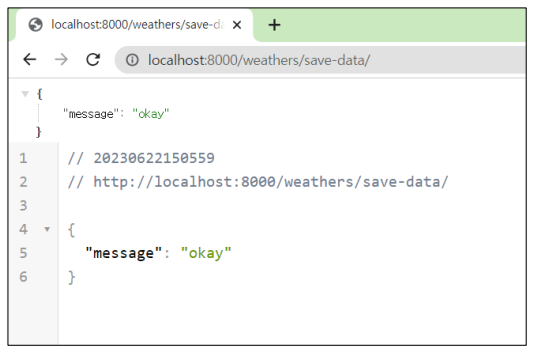

    - 저장 결과 확인

    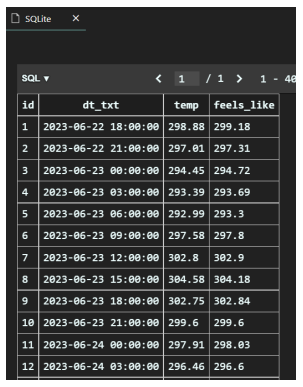

##### C. 저장된 전체 데이터 조회
- ORM 을 활용해 전체 데이터를 확인합니다.
    - views.py 예시

    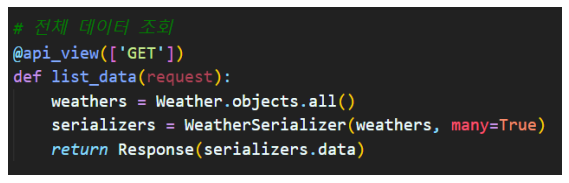

    - 결과 화면 예시

    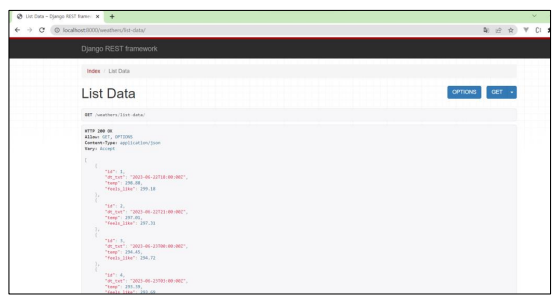

##### D. 특정 조건의 데이터 확인하기: 섭씨 30도가 넘는 시간대만 조회
- 저장한 데이터 중 조건에 맞는 데이터만 반환해 줍니다.
    - 전체 데이터를 반복하며 섭씨 30도가 넘는 데이터만 새로운 리스트로 만들어 줍니다.
    - 새로운 리스트를 Serializer 를 통해 사용자에게 반환합니다.

    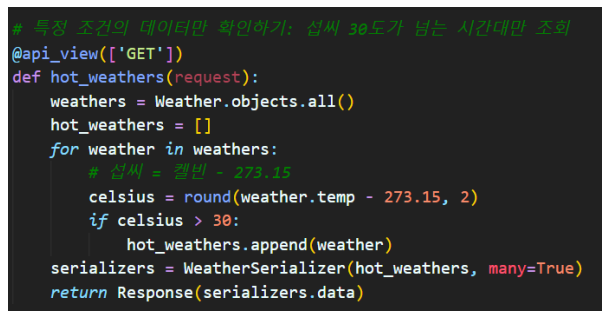

- 결과 화면 예시
  
    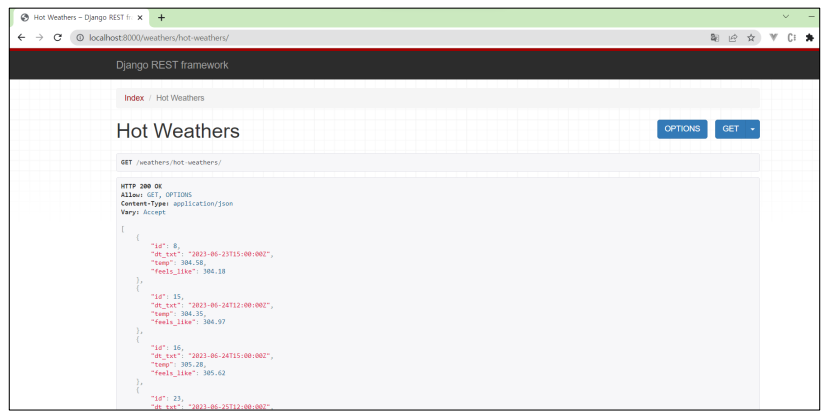